This notebook has been created to prove that all endpoints are working correclty.

In [8]:
import pandas as pd
import src.utils as ut
import requests

If we want the engine object, from my point of view it is better to create a function that returns the engine instead of having it in the middle of a .py file. In this way you have the control about when do you want to instantiate your engine because you might need to import the config.py just to have access to some configuration parameters and not always to get the engine object.

In [9]:
import config.config as db
engine = db.connect_db()

 I have created a .py with some functions that creates a database from scratch (getting the db name from our config file).
 this function is really calling to other functions:
  *  create_connection_db():
     - create the connection to the db returning the engine object
  * delete_db(engine):
     - delete our database in case we want to start with a clean one
  * create_db(engine):
     - create our db using the name of the db on our conf.py 
  * create_tables_db(engine):
     - create all tables I will be needing for the project. It is not an sql script, it is 
         sqlAlchemy code.

In [10]:
import src.db_creation as db
db.create_db_and_tables()

We are loading here csv

In [11]:
df = pd.read_csv("./data/movie_quotes_.csv")
df.columns=["index", "quote", "character", "artist", "movie", "year", "sex"]
df.head(2)

,index,quote,character,artist,movie,year,sex
0,1,"""Frankly, my dear, I don't give a damn.""",Rhett Butler,Clark Gable,Gone with the Wind,1939,M
1,2,"""I'm gonna make him an offer he can't refuse.""",Vito Corleone,Marlon Brando,The Godfather,1972,M


We are executing a function from our utils.py file to replace problematic simbols

In [12]:
ut.replace_df(df).head(2)

,index,quote,character,artist,movie,year,sex
0,1,"Frankly, my dear, I don´t give a damn.",Rhett Butler,Clark Gable,Gone with the Wind,1939,M
1,2,I´m gonna make him an offer he can´t refuse.,Vito Corleone,Marlon Brando,The Godfather,1972,M


This is our first end point, the first one I created so that I could use it to insert the
info from the csv on the DB.

***So we are going to start with [POST] endpoints***

I could've created a function in our utils.py file, but I've preferred leave here the code for
a better understanding.

This endpoint is calling to all the database functions and checks to be sure all data are
loaded correcly. For a summary I will leave here the calls:
* id_artist, msg1 = sql.insertartist(artist)
* id_character, msg2 = sql.insertcharacter(character, sex, id_artist)
* id_quote, msg3 = sql.insertquote(quote, id_character)
* id_movie, msg4 = sql.insertmovie(movie, year, id_character)


In [14]:
url = 'http://127.0.0.1:5000/insertmoviequote'

for i, fila in df.iterrows():
    json_movie = ut.create_json_movie(fila["artist"], fila["character"], fila["quote"], fila["movie"], fila["year"], fila["sex"])
    id_movie_quote = requests.post(url, data = json_movie)
    


Because we have created the DB in a way to show we can craate different tables using FKs, makes no sense to do an insert endpoint for every table because almost all the table are related between them, which mean, the user will be forced to give all the information to fill any of our tables, due to the Fks and their realtionship.

Actually, there is always only one table that doesn't have a fk. In my case is the artist table so, lets see this endpoint.

In [73]:
url = 'http://127.0.0.1:5000/insertartist'
myobj = {
    "artist": "Diego Diaz"
}

x = requests.post(url, data = myobj)


In [70]:
# As we can see if we insert an artist the endpoint will return the name of the artist 
# inserted, the id of the data base of the artist created and a message of confirmation
x.json()

{'artist': 'Diego Diaz', 'id': 78, 'msg': 'Artist inserted into DB'}

In [71]:
#Lets see what would happend if we try to introduce the same artist
myobj = {
    "artist": "Diego Diaz"
}

x = requests.post(url, data = myobj)
x.json()

{'artist': 'Diego Diaz', 'id': 78, 'msg': 'Artist Diego Diaz already exist'}

In [72]:
# The endpoint return the Id of the artist and a message where it says the artist
# already exist

Let's see now an example of a deletion endpoint, trying to delete the artist we just created.

In [74]:

url = 'http://127.0.0.1:5000/deleteartist'
myobj = {
    "artist": "Diego Diaz"
}

x = requests.post(url, data = myobj)
x

<Response [200]>

In [75]:
x.json()

{'artist': 'Diego Diaz', 'id': 0, 'msg': 'Artist deleted from DB'}

In [76]:
# confirmation message of the artist deletion 
# What if we try to delete it again?
x = requests.post(url, data = myobj)
x

<Response [200]>

In [77]:
x.json()

{'artist': 'Diego Diaz',
 'id': -1,
 'msg': "Artist Diego Diaz doesn't  exist in the DB"}

In [ ]:
# Our checking have worked correctly and it returns us a message saying that artist
# doesn't exist in our DB

Everything is working fine so far, let's try to modify an artist with our update endpoint:

In [80]:
url = 'http://127.0.0.1:5000/updateartist'
myobj = {
    "artist": "Clark Gable",
    "artist_new": "Clark Cables"
}

x = requests.post(url, data = myobj)
x.json()

{'artist': 'Clark Gable',
 'artist_new': 'Clark Cables',
 'msg': 'Artist updated in DB'}

From here we start with [GETs] endpoints. 
I'm going to group these endpoints :

     1) Group that returns quotes
     2) Sentimental anaylisis group (/sa)
     3) Endpoints executed by the browser

Getting all quotes

In [18]:
url = 'http://127.0.0.1:5000/quotes'
res = requests.get(url)
res.json()[:2]

[{'quote': 'Frankly, my dear, I don´t give a damn.'},
 {'quote': 'I´m gonna make him an offer he can´t refuse.'}]

Getting quotes by Artist (Actor or Actress)

In [20]:
url = 'http://127.0.0.1:5000/quotesbyartist/Marlon brando'
res = requests.get(url)
res.json()[:2]

[{'quote': 'I´m gonna make him an offer he can´t refuse.',
  'artist_name': 'Marlon Brando'},
 {'quote': 'You don´t understand! I coulda had class. I coulda been a contender. I could´ve been somebody, instead of a bum, which is what I am.',
  'artist_name': 'Marlon Brando'}]

Getting quotes by the sex of the Character 

In [21]:
url = 'http://127.0.0.1:5000/quotesbysex/F'
res = requests.get(url)
res.json()[:2]

[{'quote': 'Toto, I´ve a feeling we´re not in Kansas anymore.',
  'artist_name': 'Judy Garland',
  'sex': 'F'},
 {'quote': 'All right, Mr. DeMille, I´m ready for my close-up.',
  'artist_name': 'Gloria Swanson',
  'sex': 'F'}]

Here we have our second group:

  2) Sentimental anaylisis group (/sa)

***Note* = To tokenize the quotes is a very slow process that makes the sentimental analisys endpoints kind of useless.***

***So I have created a new column on my quote table called tokenized, where every time I insert a quote, it will be tokenized and the sentimental endpoints only need to do the analysis. In this way we have an instant response.***

Sentimental analysis of all quotes

In [33]:
url = 'http://127.0.0.1:5000/sa/quotes'
res = requests.get(url)
res.json()[10:12]

[{'quote': 'What we´ve got here is failure to communicate.',
  'sentiment': -0.3166666667},
 {'quote': 'I love the smell of napalm in the morning.', 'sentiment': 0.5}]

This is an special one, not related with anything on the database. But it is a cool endpoint as you can set any sentence and the endpoint will give you the Sentimental analysis of it.

In [42]:
url = 'http://127.0.0.1:5000/sa/"I feel great'
res = requests.get(url)
res.json()

{'Sentimental Analysis': 0.8, 'quote': '"I feel great'}

Sentimental analysis by sex

In [38]:
url = 'http://127.0.0.1:5000/sa/quotesbysex/F'
res = requests.get(url)
res.json()[1:3]

[{'artist_name': 'Gloria Swanson',
  'quote': 'All right, Mr. DeMille, I´m ready for my close-up.',
  'sex': 'F',
  'sentiment': 0.2428571429},
 {'artist_name': 'Bette Davis',
  'quote': 'Fasten your seatbelts. It´s going to be a bumpy night.',
  'sex': 'F',
  'sentiment': 0.0}]

Now we are on a new group, which is really a subgroup.

I have created some endpoints that are able to be watched in a readible way on the brower (/br). 
I did just a couple of endopoint just to prove it was posible to create a table on the browser
using a simply way.
So this endpoints are only visible no the brower

In [ ]:
url = 'http://127.0.0.1:5000/br/quotes"

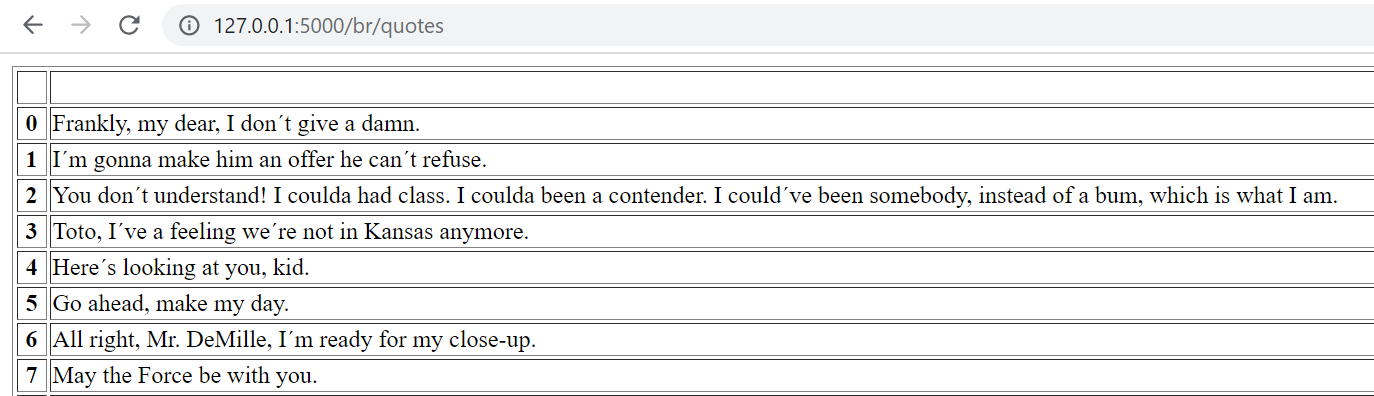

Same thing for the sentimental analysis

In [39]:
url = 'http://127.0.0.1:5000/sa/br/quotes'

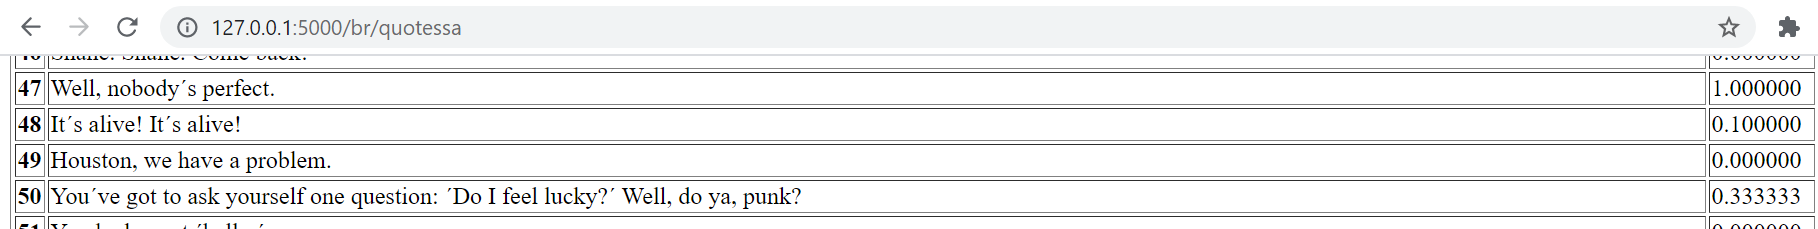

Finally I have created an endpoint that display a sns.histplot() on the browser. I had to create
a littel html for that, and due the few quantity of data I have in my dataframe(DB) I only 
have created one chart.

In [ ]:
url = 'http://127.0.0.1:5000/sa/br/quotes_chart'

It is not a great chart but we can see a the distribution of the sentimental analisys of all the quotes that looks like simiilar to a normal distribution.

Screenshot below

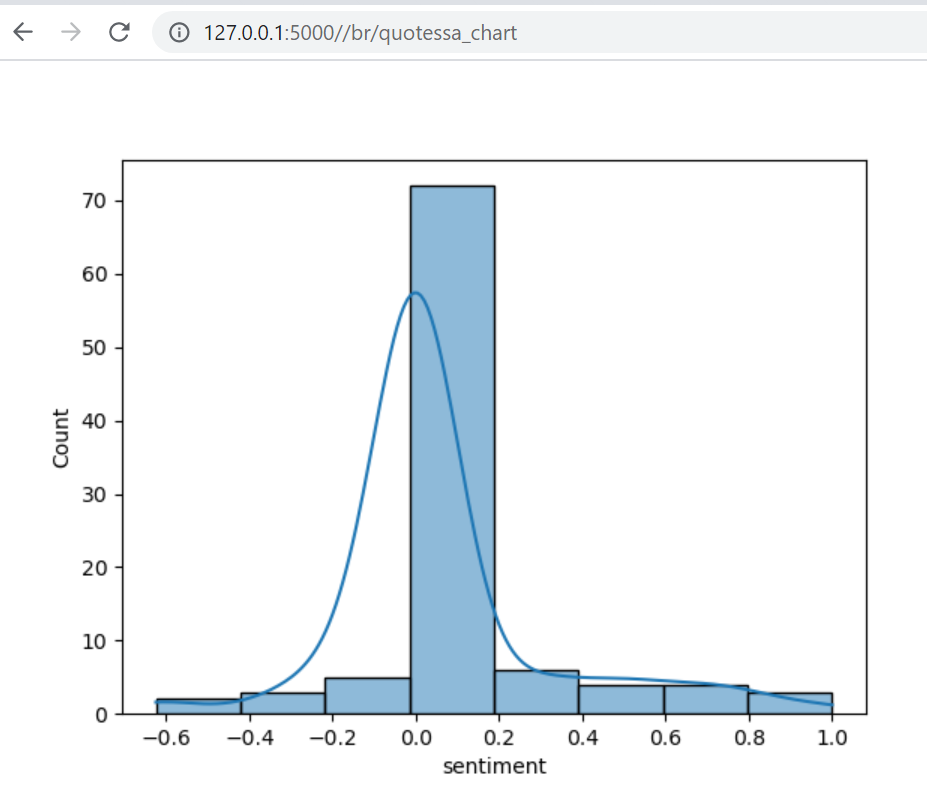

Here we can see another plot on the browser where we can see the sentiment analisys of the quotes
categorized by the Sex. I'm leaving the code of the endopoint below:
```
python
@app.route('/br/quotesbysexsa_chart',methods=['GET'])
def quotesbysexsa_chart():
    img = io.BytesIO()
    quotes_sn = sql.quotesbysexsa("B")
    df = pd.DataFrame(eval(quotes_sn))
    sns.histplot(data=df, x="sentiment", hue="sex")
    plt.savefig(img, format='png')
    plt.close()
    img.seek(0)
    plot_url = base64.b64encode(img.getvalue()).decode('utf8')
    return render_template("index.html",plot_url=plot_url)
    ```

In [66]:
url = 'http://127.0.0.1:5000/sa/br/quotesbysex_chart'

Screenshot below

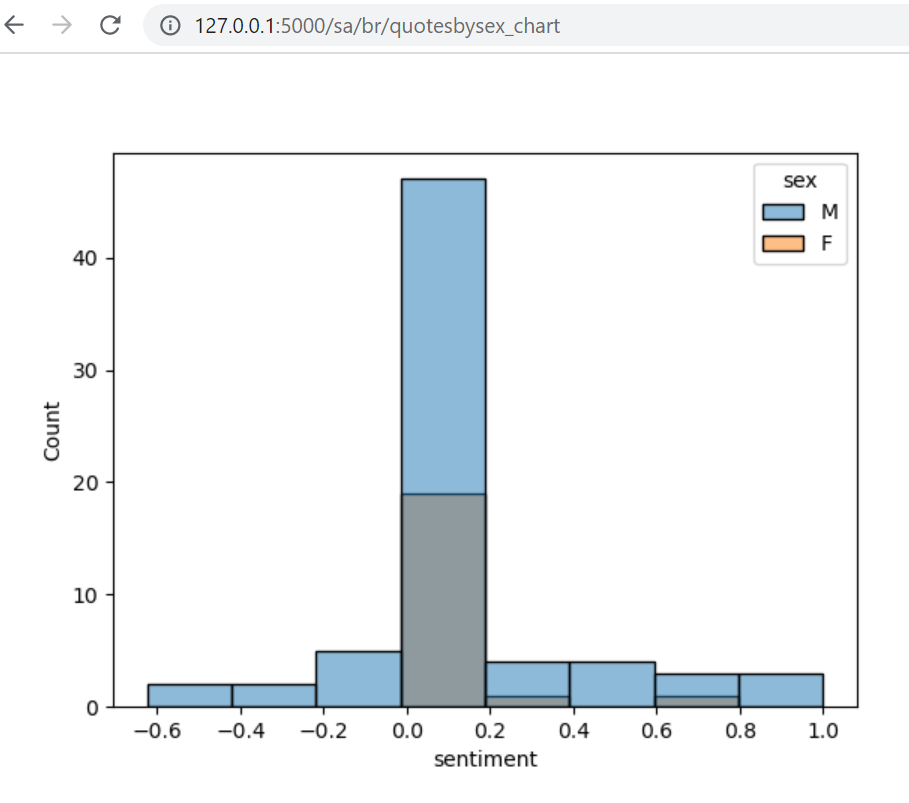